<a href="https://colab.research.google.com/github/falcatraz/FruitClassification/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Francisco Alcaraz
# Final Project
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import glob
import cupy as cp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab.patches import  cv2_imshow
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

NUM_IMAGES = 1000 # number of images we will work with
REQUIRED_DIMS = (256, 204) # width and height since that is how CV likes it
REDUCED_DIM = (256*204*3) # flattened dimensions
NORMALIZER = 255.0 # for normalizing image data
PEACH = 0 # value of peach
BANANA = 1 # value of banana
MANGO = 2 # value of mango

In [2]:
# inserting images into lists to process the data
peaches = [cv.imread(file) for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/Peach/*.png")]
bananas = [cv.imread(file) for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/Banana/*.png")]
mangos = [cv.imread(file) for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/Mango/*.png")]

In [3]:
# converting images to RGB
for i in range(NUM_IMAGES):
  peaches[i] = cv.resize(peaches[i], dsize=REQUIRED_DIMS)
  peaches[i] = cv.cvtColor(peaches[i], cv.COLOR_BGR2RGB)

  bananas[i] = cv.resize(bananas[i], dsize=REQUIRED_DIMS)
  bananas[i] = cv.cvtColor(bananas[i], cv.COLOR_BGR2RGB)

  mangos[i] = cv.resize(mangos[i], dsize=REQUIRED_DIMS)
  mangos[i] = cv.cvtColor(mangos[i], cv.COLOR_BGR2RGB)

In [4]:
# having two sets of data to work with. One with the images flattened into a 1-D array
# another to keep  the images as they are, and then normalizing the data
peachesnd = np.array(peaches).reshape(-1, REDUCED_DIM)/NORMALIZER

bananasnd = np.array(bananas).reshape(-1, REDUCED_DIM)/NORMALIZER

mangosnd = np.array(mangos).reshape(-1, REDUCED_DIM)/NORMALIZER

In [5]:
# creating the labels for our massive dataframe
labels_peach = ['peaches']*NUM_IMAGES
s_peach = pd.Series(labels_peach)

labels_bananas = ['bananas']*NUM_IMAGES
s_bananas = pd.Series(labels_bananas)

labels_mangos = ['mangos']*NUM_IMAGES
s_mangos = pd.Series(labels_mangos)

In [6]:
# creating individual instances of dataframes so we can join them all together to do ML stuff
dfpeach = pd.DataFrame(peachesnd)
dfpeach = dfpeach.join(s_peach.rename('fruit'))

dfbananas = pd.DataFrame(bananasnd)
dfbananas = dfbananas.join(s_bananas.rename('fruit'))

dfmangos = pd.DataFrame(mangosnd)
dfmangos = dfmangos.join(s_mangos.rename('fruit'))

In [7]:
# creating the dataframe
df = pd.concat([dfpeach, dfbananas, dfmangos])

In [8]:
# splitting our data
xtrain, xtest, ytrain, ytest = train_test_split(df.drop('fruit', axis=1), df['fruit'], test_size=.2, random_state=142)
xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain, test_size=.2, random_state=142)

In [ ]:
# setting up parameters
best_params = {}
best_accuracy = 0
nneigh = [5,7,9,11]
mets = ['euclidean', 'manhattan', 'minkowski']

# finding the best parameters
for n in nneigh:
  for m in mets:
      # instantiate and train the model, then obtain the accuracy score
      knn = KNeighborsClassifier(n_neighbors=n, metric=m, n_jobs = -1)
      knn.fit(xtrain, ytrain)
      # getting prediction
      ypred = knn.predict(xvalid)
      # getting accuracy score
      accurate = accuracy_score(yvalid, ypred)

      # obtaining the best accuracy score and parameters
      if accurate > best_accuracy:
        best_accuracy = accurate
        best_params['n_neighbors'] = n
        best_params['metric'] = m

knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], metric=best_params['metric'])
knn.fit(xtrain, ytrain)

KNeighborsClassifier(metric='manhattan')

In [ ]:
print(f"Best N: {best_params['n_neighbors']}\nBest Metric: {best_params['metric']}")

Best N: 5
Best Metric: manhattan


In [ ]:
# prediction and classification report
ypred = knn.predict(xtest)
print(classification_report(ytest, ypred, labels=["peaches", "bananas", "mangos"]))

              precision    recall  f1-score   support

     peaches       0.90      0.93      0.91       200
     bananas       0.84      0.81      0.82       201
      mangos       0.86      0.87      0.86       199

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



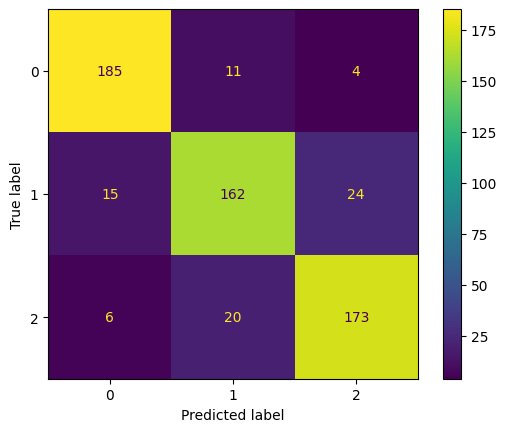

In [ ]:
# printing the confusion matrix for KNN
cmatrix = confusion_matrix(ytest, ypred, labels=["peaches", "bananas", "mangos"])
cm_display = ConfusionMatrixDisplay(confusion_matrix=cmatrix)
cm_display.plot()
plt.show()

In [9]:
# preparing to use convolutional NN
x_list = peaches + bananas + mangos

labels_peach = [PEACH]*NUM_IMAGES
labels_bananas = [BANANA]*NUM_IMAGES
labels_mangos = [MANGO]*NUM_IMAGES
y_list = labels_peach + labels_bananas + labels_mangos

In [10]:
X = np.array(x_list)
Y = np.array(y_list)

In [11]:
# data split into training, testing, and validation splits
xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(X, Y, test_size=.3, random_state=142)
xtrain_c, xvalid_c, ytrain_c, yvalid_c = train_test_split(xtrain_c, ytrain_c, test_size = .3, random_state=142)

In [12]:
# Normalization
xtrain_c2 =  xtrain_c/NORMALIZER
xtest_c2 = xtest_c/NORMALIZER
xvalid_c2 = xvalid_c/NORMALIZER

In [27]:
# now using convolutional NN
cnnModel = keras.Sequential()
cnnModel.add(layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(204,256,3)))
cnnModel.add(layers.Conv2D(filters=32, kernel_size=(3,3)))
cnnModel.add(layers.MaxPool2D(pool_size=(3,3)))
cnnModel.add(layers.Dropout(0.5))
cnnModel.add(layers.Flatten())
cnnModel.add(layers.Dense(50, activation="relu"))
cnnModel.add(layers.Dense(100, activation="relu"))
cnnModel.add(layers.Dense(50, activation="relu"))
cnnModel.add(layers.Dense(3, activation='sigmoid'))
cnnModel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnnModel.fit(xtrain_c2, ytrain_c, batch_size = 10, epochs=15, validation_data=[xvalid_c2, yvalid_c])

Epoch 1/15
147/147 [==============================] - 4s 15ms/step - loss: 0.9849 - accuracy: 0.6571 - val_loss: 0.5051 - val_accuracy: 0.8048
Epoch 2/15
147/147 [==============================] - 1s 8ms/step - loss: 0.2844 - accuracy: 0.8857 - val_loss: 0.2225 - val_accuracy: 0.9143
Epoch 3/15
147/147 [==============================] - 1s 8ms/step - loss: 0.1564 - accuracy: 0.9435 - val_loss: 0.5081 - val_accuracy: 0.8111
Epoch 4/15
147/147 [==============================] - 1s 8ms/step - loss: 0.2546 - accuracy: 0.9143 - val_loss: 0.5686 - val_accuracy: 0.8048
Epoch 5/15
147/147 [==============================] - 1s 8ms/step - loss: 0.1140 - accuracy: 0.9565 - val_loss: 0.4295 - val_accuracy: 0.8683
Epoch 6/15
147/147 [==============================] - 1s 8ms/step - loss: 0.0350 - accuracy: 0.9884 - val_loss: 0.3966 - val_accuracy: 0.8905
Epoch 7/15
147/147 [==============================] - 1s 8ms/step - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.3772 - val_accuracy: 0.9063
Epoch

In [28]:
cnnModel.evaluate(xtest_c2, ytest_c)

29/29 [==============================] - 0s 9ms/step - loss: 0.4485 - accuracy: 0.9200


[0.4485227167606354, 0.9200000166893005]

In [ ]:
y_cnn = cnnModel.predict(xtest_c2).argmax(axis=1)
print(classification_report(ytest_c, y_cnn))

29/29 [==============================] - 1s 27ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       300
           1       0.87      0.95      0.91       306
           2       0.91      0.85      0.88       294

    accuracy                           0.92       900
   macro avg       0.93      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



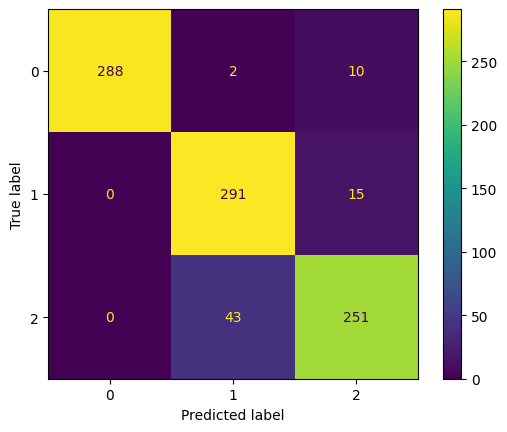

In [ ]:
# printing the confusion matrix for KNN
cmatrix2 = confusion_matrix(ytest_c, y_cnn)
cm_display2 = ConfusionMatrixDisplay(confusion_matrix=cmatrix2)
cm_display2.plot()
plt.show()

In [ ]:
def displayPred(xquiz, yquiz):
  x = cv.cvtColor(xquiz, cv.COLOR_BGR2RGB)
  cv2_imshow(x)
  if yquiz == 0:
    print("Prediction: Peach\n")
  elif yquiz == 1:
    print("Prediction: Banana\n")
  elif yquiz == 2:
    print("Prediction: Mango\n")
  else:
    print("Invalid")

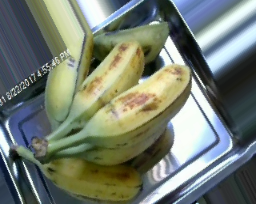

Prediction: Banana



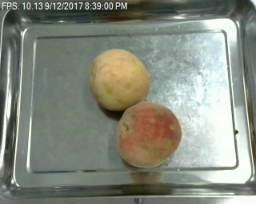

Prediction: Peach



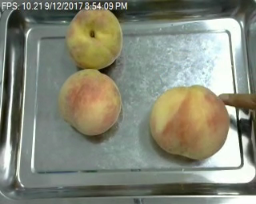

Prediction: Peach



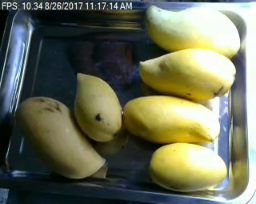

Prediction: Mango



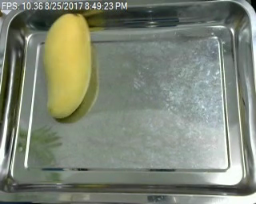

Prediction: Mango



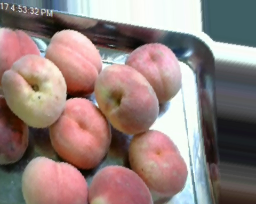

Prediction: Peach



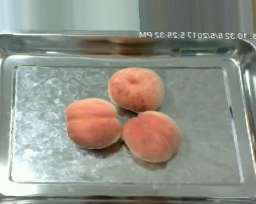

Prediction: Peach



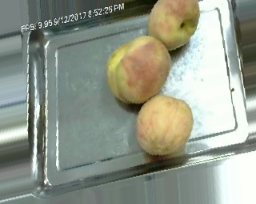

Prediction: Mango



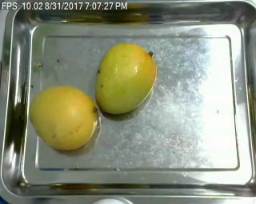

Prediction: Mango



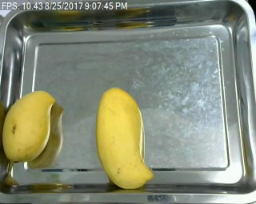

Prediction: Mango



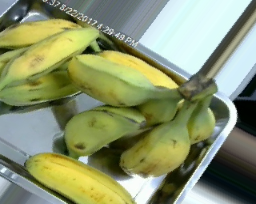

Prediction: Banana



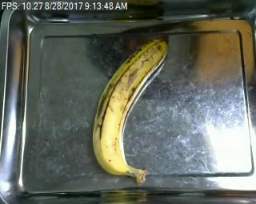

Prediction: Banana



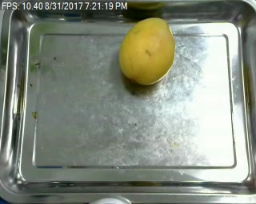

Prediction: Mango



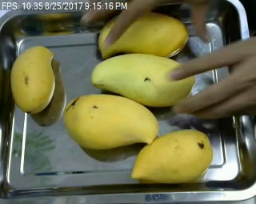

Prediction: Mango



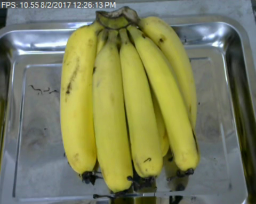

Prediction: Banana



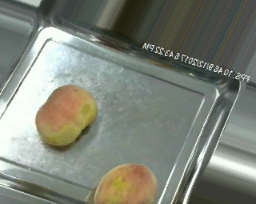

Prediction: Peach



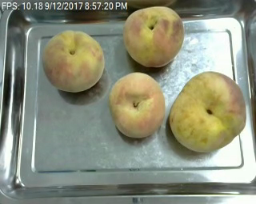

Prediction: Peach



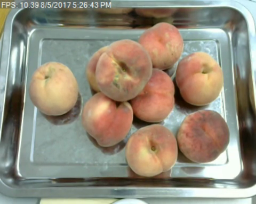

Prediction: Peach



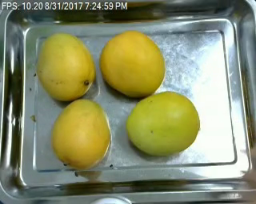

Prediction: Mango



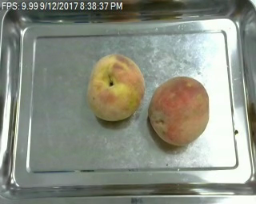

Prediction: Peach



In [ ]:
for i in range(0, 20):
  displayPred(xtest_c[i], y_cnn[i])